# Project 2: Wind Simulator Design
>**Date Created**: 10 February 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [247]:
import numpy as np
import scipy as sp
import sympy as smp

from matplotlib import pyplot as plt
from scipy import stats

In [248]:
v_infinity = 824 # ft/ sec
alt = 20000 # ft
dt = 0.01 # sec
mu = 0 # ft/s

In [249]:
def calculate_AB(v_inf, alt, sigma_u, sigma_v, sigma_w):
    h= alt
    if h >= 1750:
        Lu, Lv, Lw = 1750, 1750, 1750
    else:
        Lu = h
        Lv = 145*h**(1/3)
        Lw = 145*h**(1/3)
        
    Arow_1 = np.array([-(np.linalg.norm(v_inf)/Lu), 0, 0, 0, 0])
    Arow_2 = np.array([0, -(v_inf/Lv), sigma_v*(1-np.sqrt(3))*(v_infinity/Lv)**(3/2), 0, 0])
    Arow_3 = np.array([0, 0, -(v_inf/Lv), 0, 0])
    Arow_4 = np.array([0, 0, 0, -(v_inf/Lw), sigma_w*(1-np.sqrt(3))*(v_infinity/Lw)**(3/2)])
    Arow_5 = np.array([0, 0, 0, 0, -(v_inf/Lw)])
    
    Brow_1 = np.array([sigma_u*(2*v_inf/np.pi/Lu)**(1/2)])
    Brow_2 = np.array([sigma_v*(3*v_inf/Lv)**(1/2)])
    Brow_3 = np.array([1])
    Brow_4 = np.array([sigma_w*(3*v_inf/Lw)**(1/2)])
    Brow_5 = np.array([1])
    
    
    A = np.vstack((Arow_1, Arow_2, Arow_3, Arow_4, Arow_5))
    B = np.vstack((Brow_1, Brow_2, Brow_3, Brow_4, Brow_5))
    
    return A, B

### a) Implement a dsicretized version of the continuous-time Dryden gust model at $\Delta t$ = $0.01$ s.

In [314]:
def calculate_AB(v_inf, alt, sigma_u, sigma_v, sigma_w):
    h= alt
    if h >= 1750:
        Lu, Lv, Lw = 1750, 1750, 1750
    else:
        Lu = h
        Lv = 145*h**(1/3)
        Lw = 145*h**(1/3)
        
    Arow_1 = np.array([-(np.linalg.norm(v_inf)/Lu), 0, 0, 0, 0])
    Arow_2 = np.array([0, -(v_inf/Lv), sigma_v*(1-np.sqrt(3))*(v_infinity/Lv)**(3/2), 0, 0])
    Arow_3 = np.array([0, 0, -(v_inf/Lv), 0, 0])
    Arow_4 = np.array([0, 0, 0, -(v_inf/Lw), sigma_w*(1-np.sqrt(3))*(v_infinity/Lw)**(3/2)])
    Arow_5 = np.array([0, 0, 0, 0, -(v_inf/Lw)])
    
    Brow_1 = np.array([sigma_u*(2*v_inf/np.pi/Lu)**(1/2)])
    Brow_2 = np.array([sigma_v*(3*v_inf/Lv)**(1/2)])
    Brow_3 = np.array([1])
    Brow_4 = np.array([sigma_w*(3*v_inf/Lw)**(1/2)])
    Brow_5 = np.array([1])
    
    
    A = np.vstack((Arow_1, Arow_2, Arow_3, Arow_4, Arow_5))
    B = np.vstack((Brow_1, Brow_2, Brow_3, Brow_4, Brow_5))
    
    return A, B

def simulate_dryden(v_inf, alt, sigma_u, sigma_v, sigma_w, dt, t_end):
    
    # Constants
    steps = int(t_end/dt)
    t_sim = np.linspace(0, t_end, steps)
    res = np.zeros((5,steps))
    
    # Calculate A and B matrices with given parameters
    A, B = calculate_AB(v_inf, alt, sigma_u, sigma_v, sigma_w)

    # Calculate multivariate normal distribution with variance 1/dt     
    P = np.array([[np.sqrt(1/dt), 0, 0, 0, 0], 
                [0, np.sqrt(1/dt), 0, 0, 0],
                [0,0, np.sqrt(1/dt),0, 0],
                [0,0,0, np.sqrt(1/dt), 0],
                [0,0,0, 0, np.sqrt(1/dt)]])
    n_t = stats.multivariate_normal([0,0,0,0,0], cov=P)
    n_i = n_t.rvs(size=steps)
    
    # Simulate state space model - discretization scheme taken from: https://en.wikipedia.org/wiki/Discretization
    for k in range(steps):
        if k == 0:
            x = np.array([0,0,0,0,0])
            res[:,k] = x
            continue
        Ad = sp.linalg.expm(A*dt)
        Bd = np.dot(np.linalg.inv(A), Ad - np.eye(5)).dot(B)
        x_kp1 = Ad @ x + np.dot(Bd.reshape(5,), n_i[k,:])
        res[:,k] = x_kp1
        x = x_kp1
    return t_sim, res

### b) Simulate the Dryden gust model for 600 seconds for three cases:
1. Light:  $\sigma_u$ = $\sigma_v$ = $\sigma_w$ = 5 ft/sec 
1. Moderate:  $\sigma_u$ = $\sigma_v$ = $\sigma_w$ = 10 ft/sec
1. Severe:  $\sigma_u$ = $\sigma_v$ = $\sigma_w$ = 20 ft/sec 

In [315]:
# Case 1 - Light Gusts
sigma_u_light, sigma_v_light, sigma_w_light = 5, 5, 5
t, results_case1 = simulate_dryden(v_infinity, alt, sigma_u_light, sigma_v_light, sigma_w_light, dt, 600)

In [316]:
# Case 2 - Moderate Gusts
sigma_u_moderate, sigma_v_moderate, sigma_w_moderate = 10, 10, 10
t, results_case2 = simulate_dryden(v_infinity, alt, sigma_u_moderate, sigma_v_moderate, sigma_w_moderate, dt, 600)

In [317]:
# Case 3 - Severe Gusts
sigma_u_severe, sigma_v_severe, sigma_w_severe = 20, 20, 20
t, results_case3 = simulate_dryden(v_infinity, alt, sigma_u_severe, sigma_v_severe, sigma_w_severe, dt, 600)

### b) Generate three plots of the gust components, one for each gust component, $u_g$, $v_g$, and $w_g$ with all three simulation data sets for a gust component on the same plot

In [318]:
def plot_gust_component(t, severe_data, moderate_data, light_data, label='w_g'):
    myDict = dict(zip(['u_g', 'v_g', 'w_g'], [0, 1, 3]))
    idx = myDict[label]
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=((15,10)), dpi = 400)
    ax.plot(t, severe_data[idx,:], label = 'Case 3 - Severe')
    ax.plot(t, moderate_data[idx,:], label = 'Case 2 - Moderate')
    ax.plot(t, light_data[idx,:], label = 'Case 1 - Light')
    ax.set_xlabel('Time (sec)', fontsize='x-large')
    ax.set_ylabel('Gust Velocity, $ft/s$',fontsize='x-large')
    ax.legend(fancybox=False,fontsize='large',edgecolor='black')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(f'Components of ${label}$',fontsize='xx-large')
    ax.grid()
    plt.show()

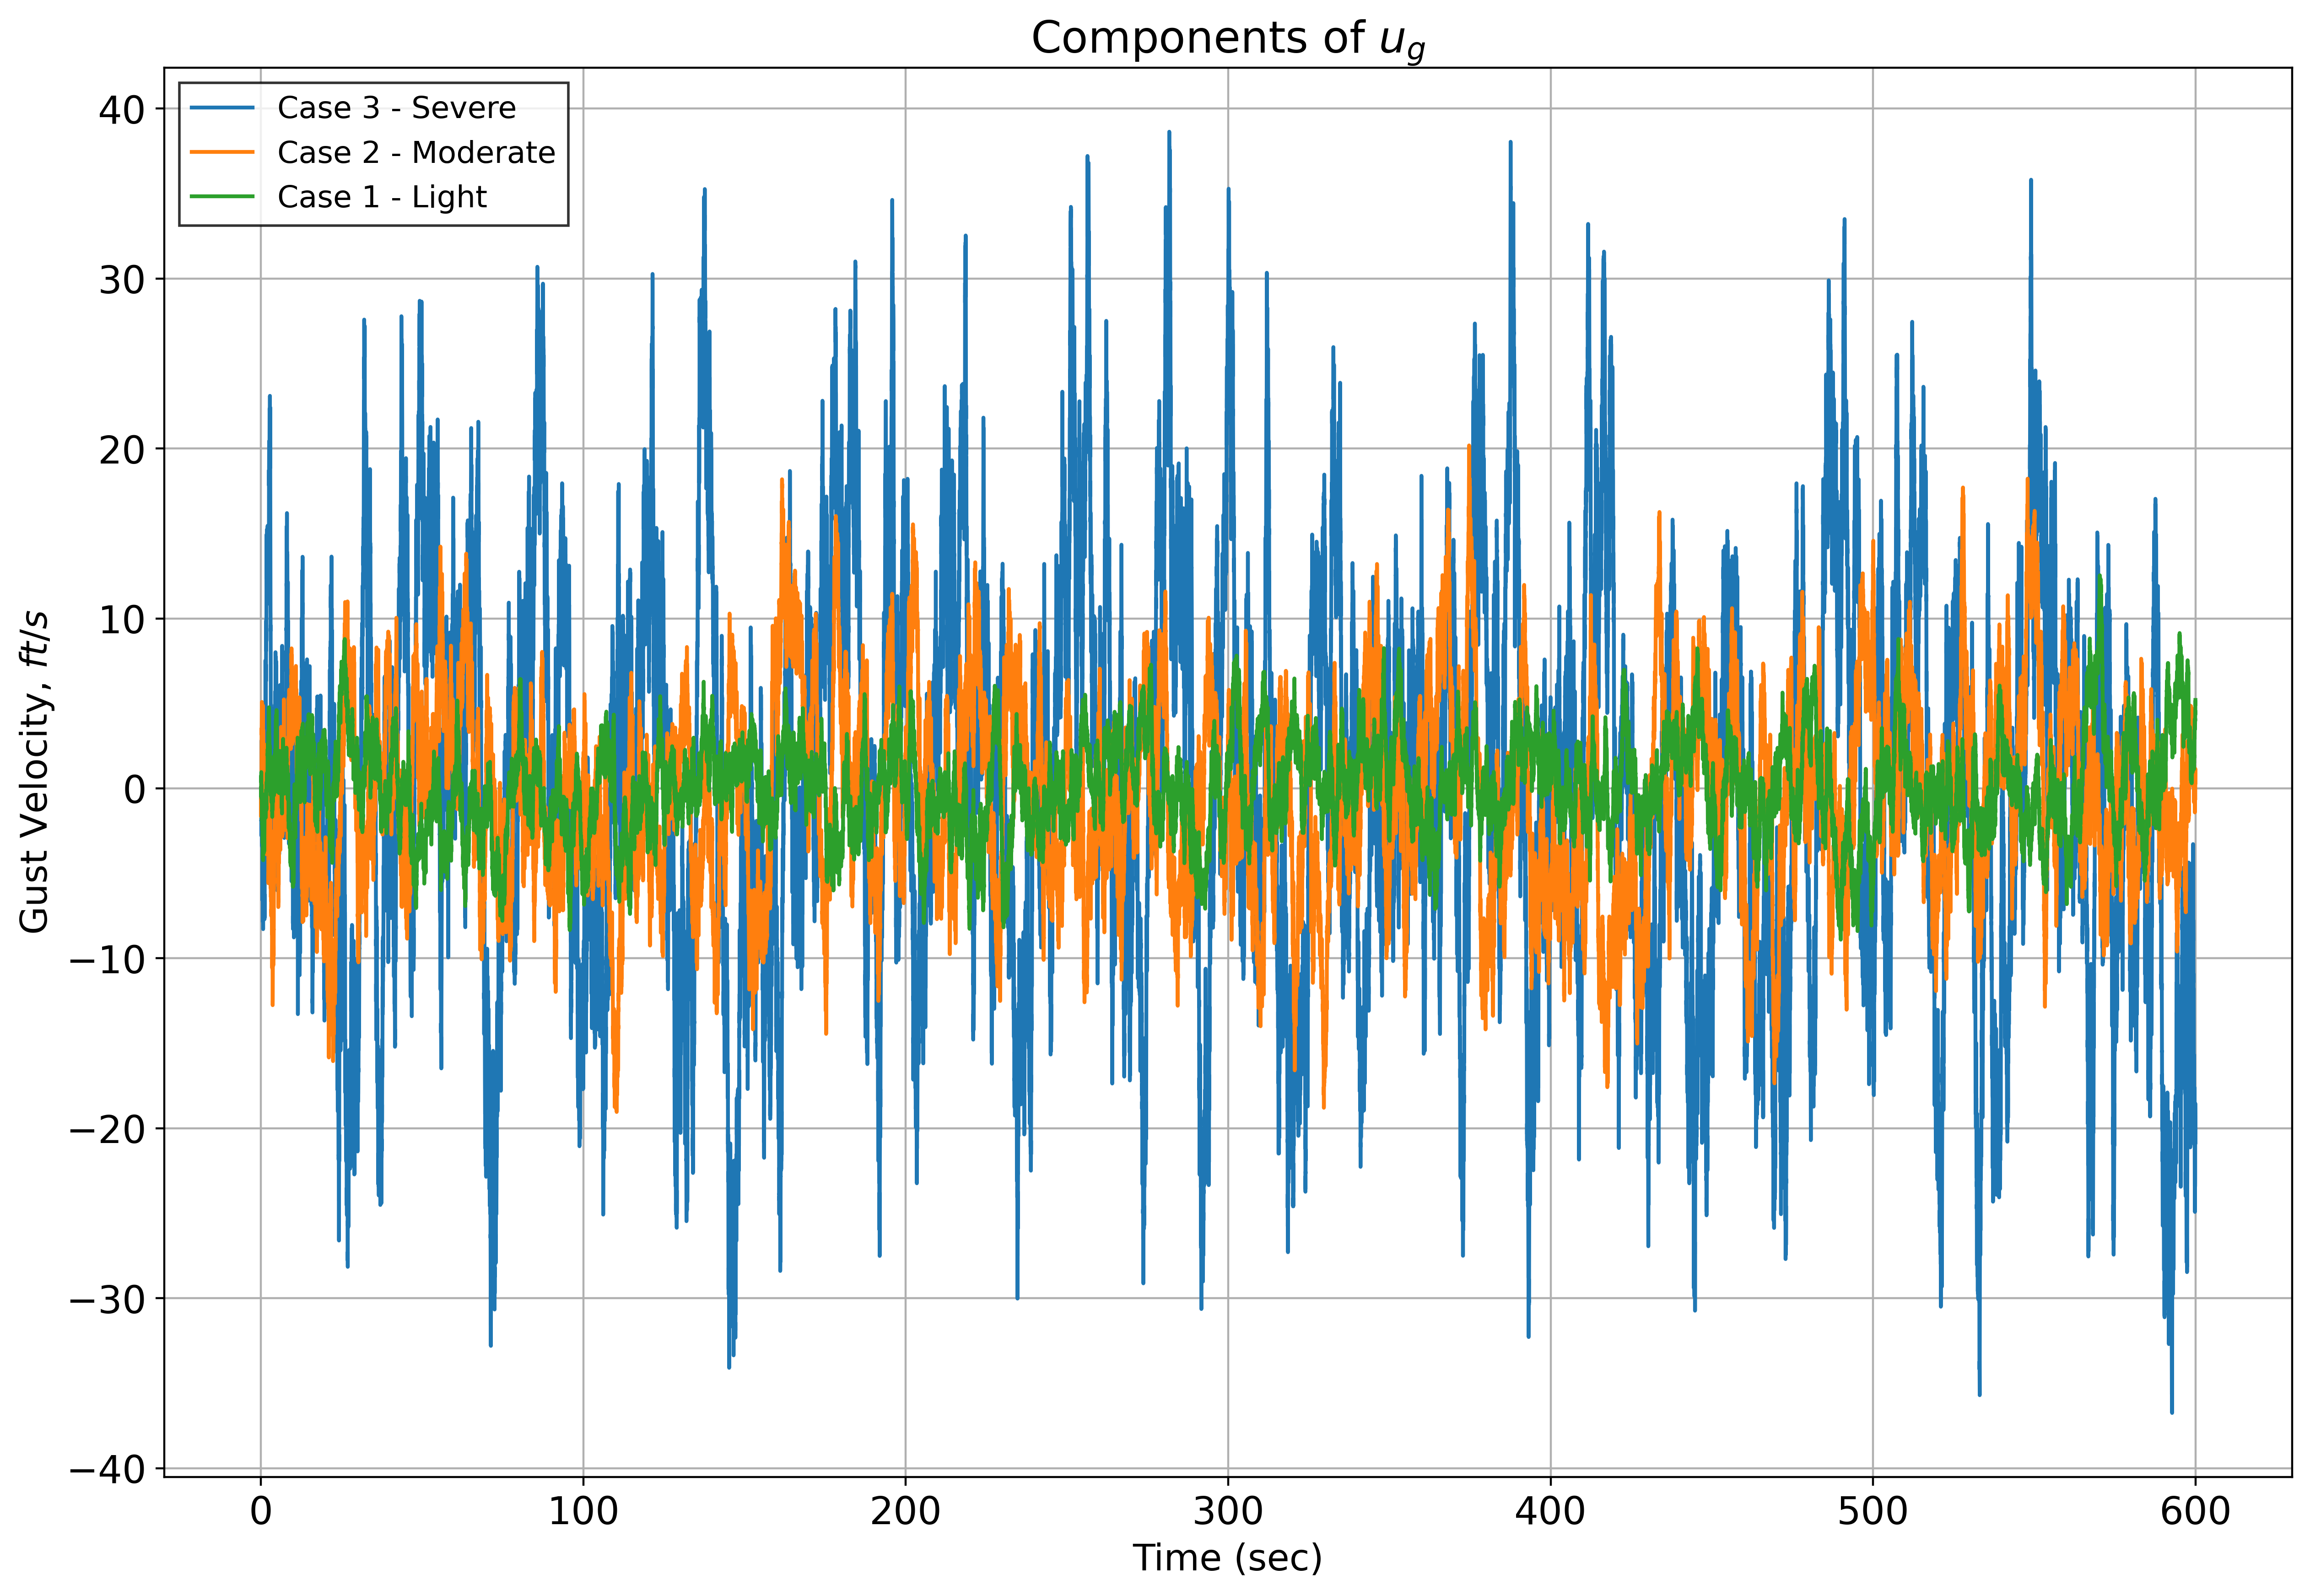

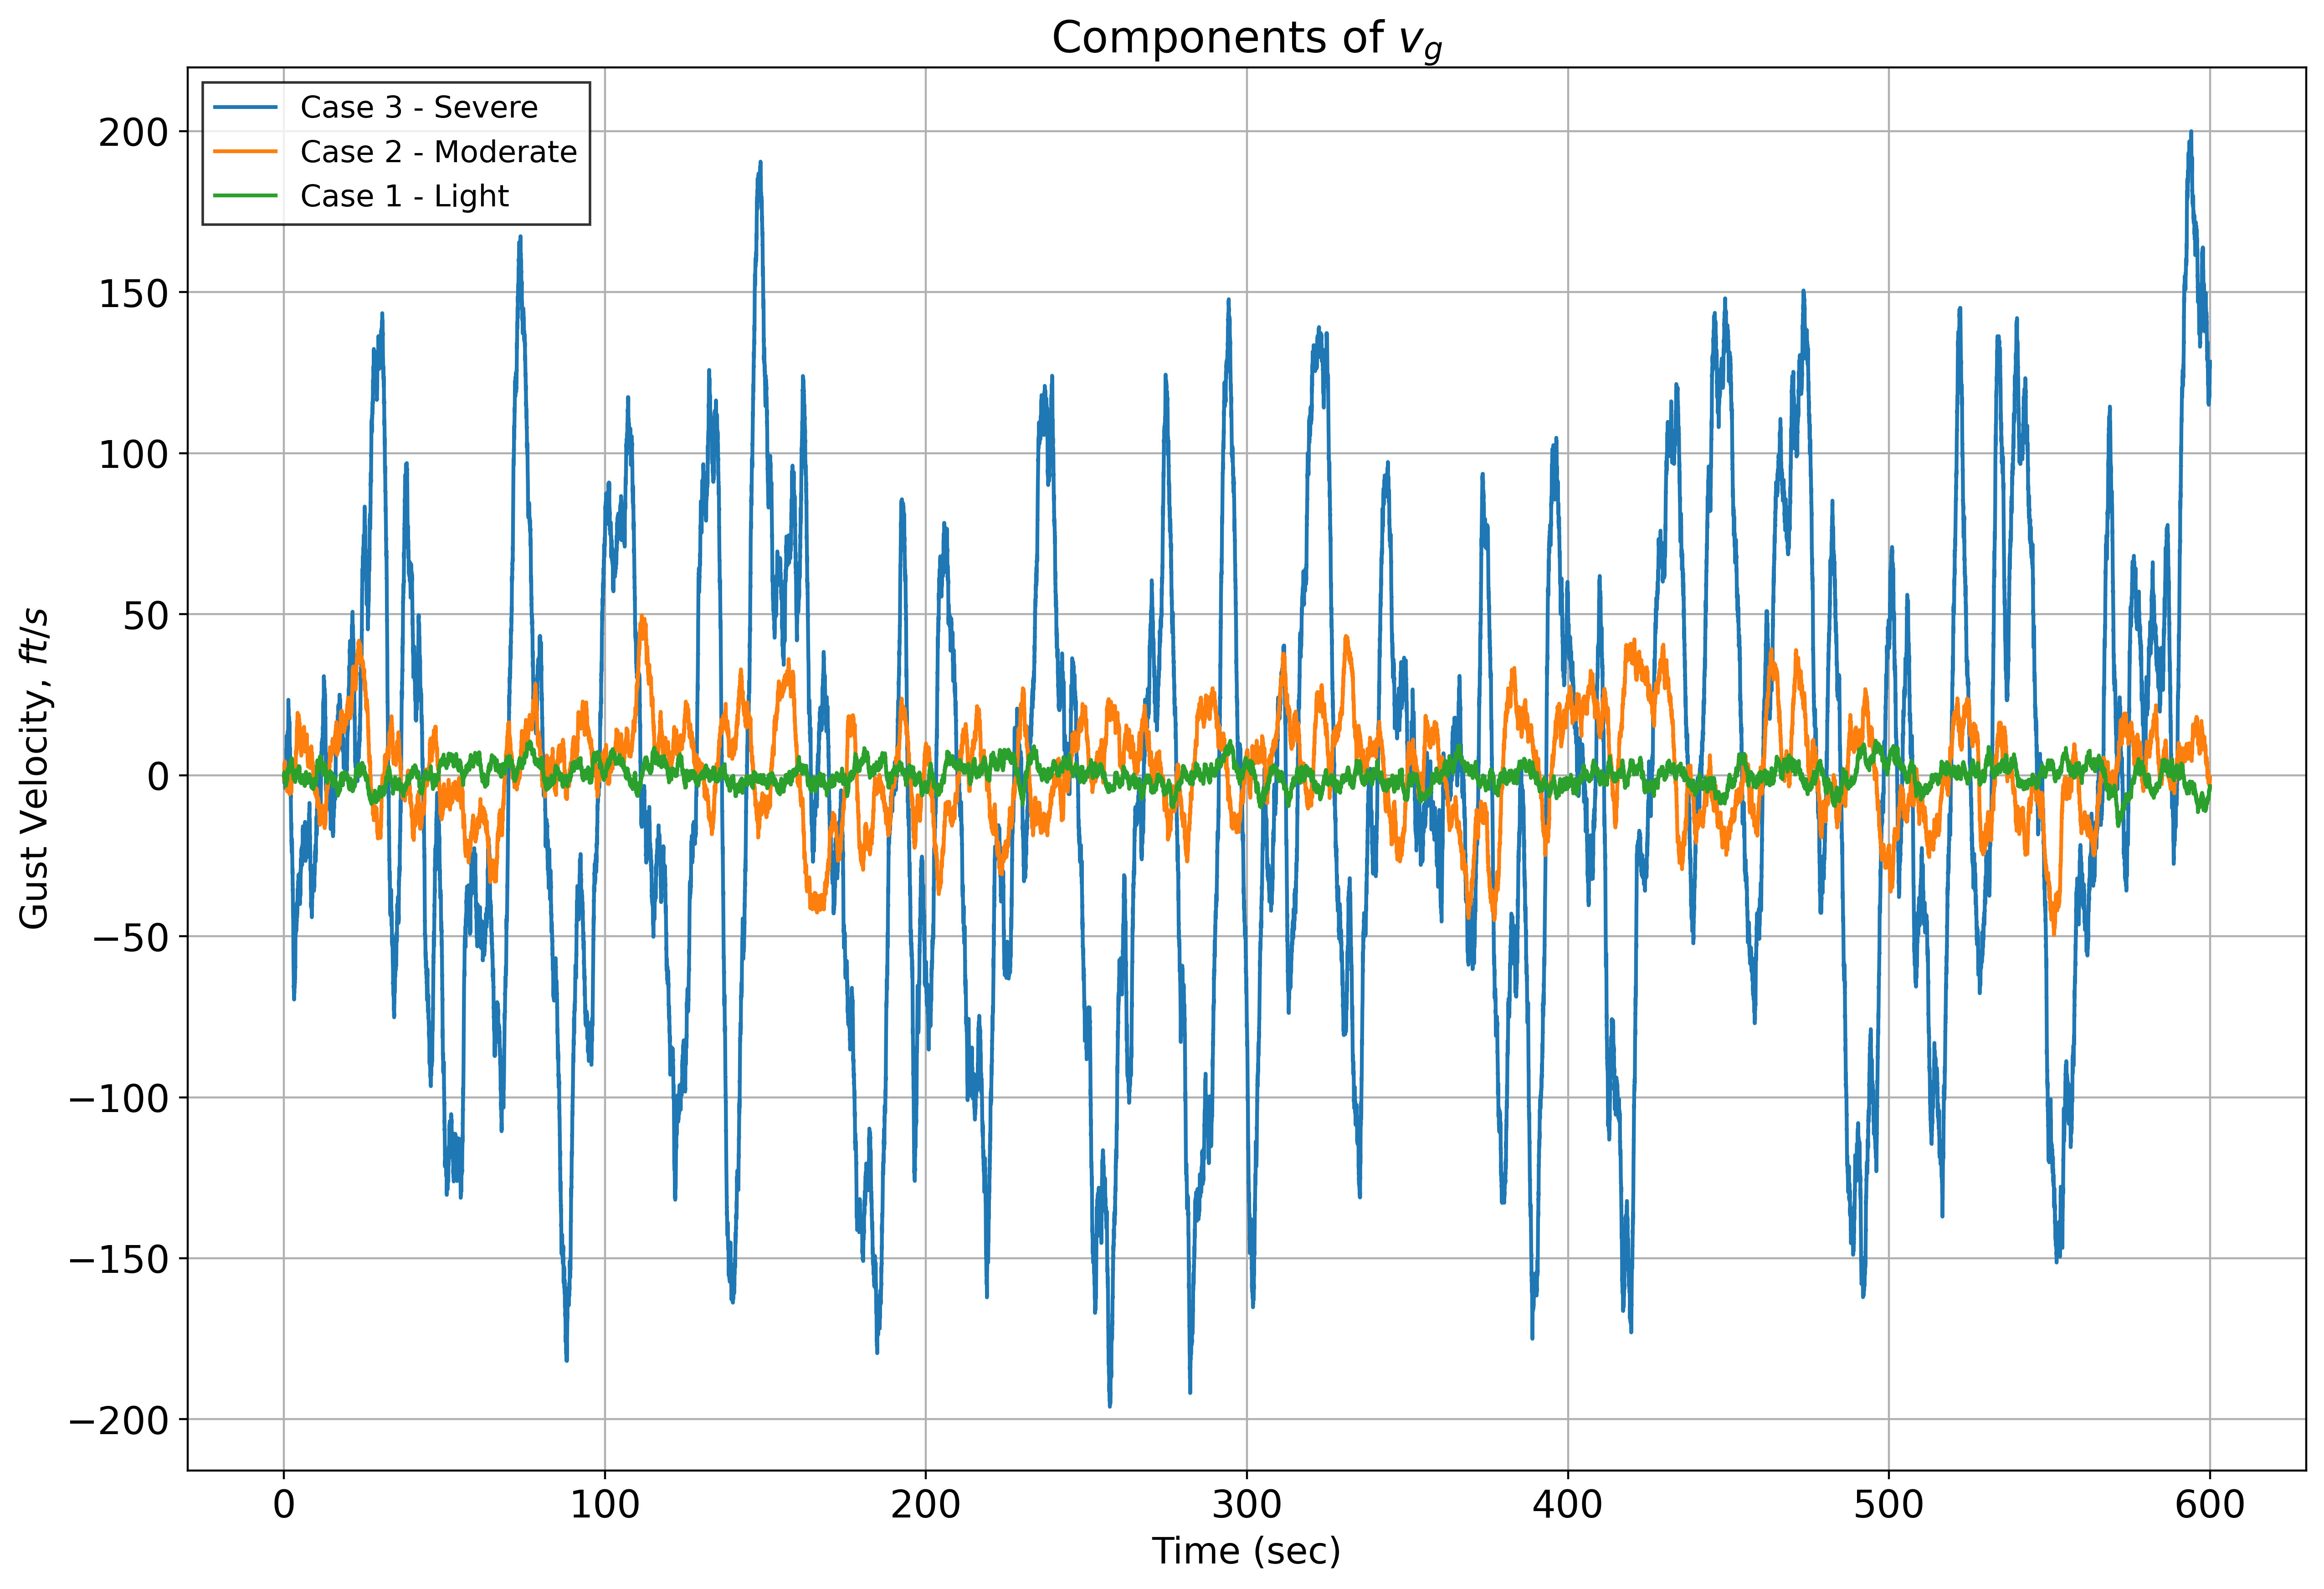

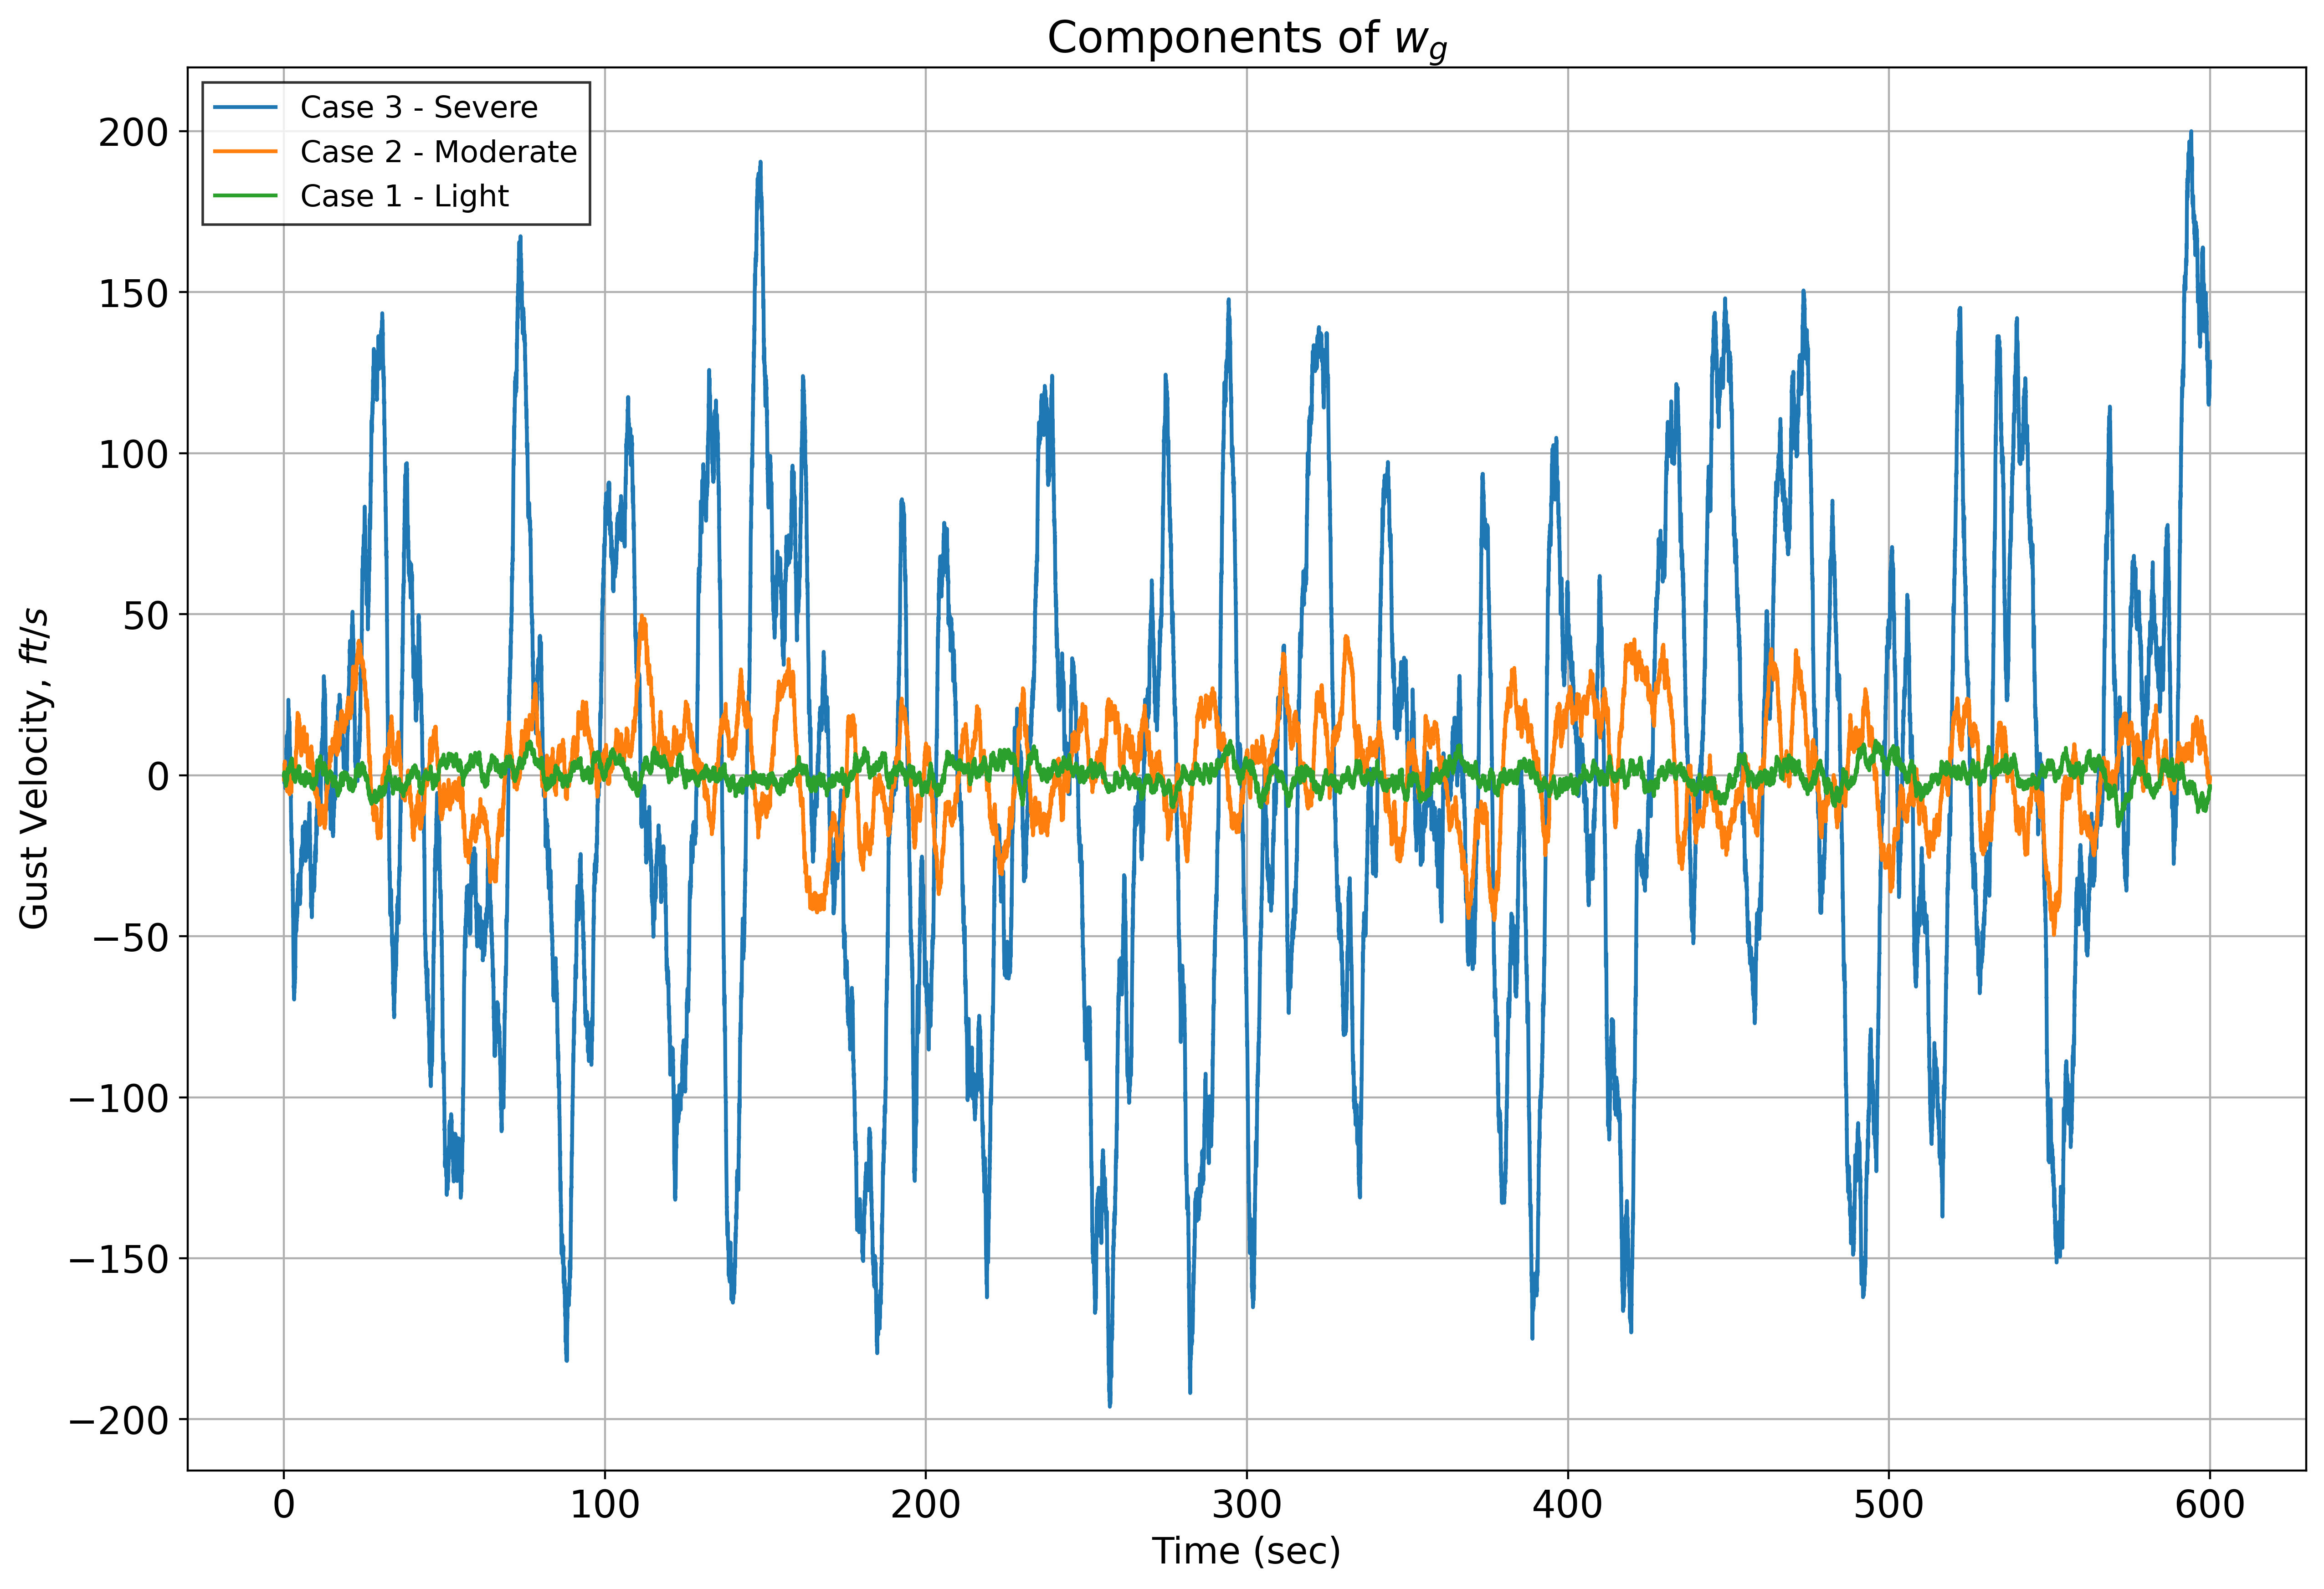

In [319]:
plot_gust_component(t, results_case3, results_case2, results_case1, 'u_g')
plot_gust_component(t, results_case3, results_case2, results_case1, 'v_g')
plot_gust_component(t, results_case3, results_case2, results_case1, 'w_g')